In [1]:
! pip install torch torchvision

In [0]:
import torch 
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# データセット

In [3]:
transform = transforms.Compose([transforms.Resize((28, 28)), 
                                                            transforms.ToTensor(),  # 画像データの操作
                                                           transforms.Normalize((0.5, ), (0.5, )) # normalization 
                                                        ])
training_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True) #genrerator . mini_batchのサイズを確定
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False) #genrerator . mini_batchのサイズを確定

0it [00:00, ?it/s]

9920512it [00:07, 1323329.68it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 58273.54it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 962543.88it/s]                             
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 21595.20it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0) #配列の軸の順番を入れ替える
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) #denormalize
  image = image.clip(0, 1) #0-1までの値に収める
  return image

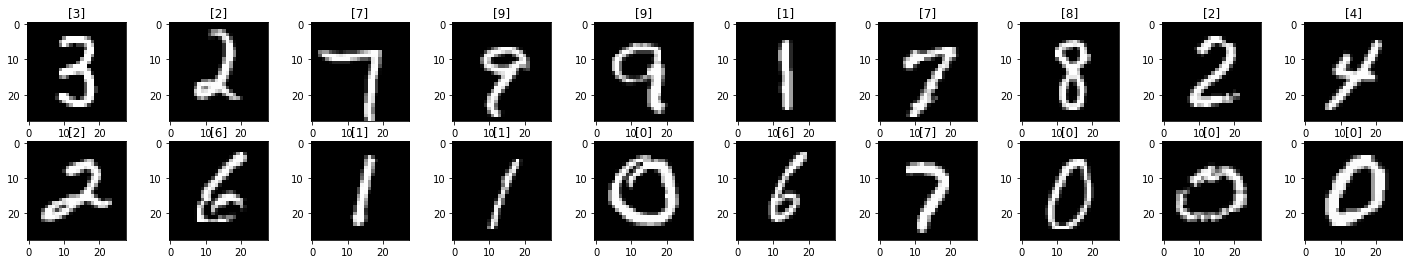

In [5]:
dataiter = iter(training_loader) #iterableなtrain_loader
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx + 1)
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])
  
  

# モデリング

In [0]:
from torch import nn
import torch.nn.functional as F

class Classifier(nn.Module):
  def __init__(self, D_in, H1, H2, D_out):
    super().__init__()
    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, D_out)
   
  
  def forward(self, X):
    X = F.relu(self.linear1(X))
    X = F.relu(self.linear2(X))
    X = self.linear3(X)
    return X
   
    

In [7]:
model = Classifier(D_in=28*28, H1=125, H2=65, D_out=10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


# 学習

In [9]:
epoch = 12
losses = []
accuracies = []

val_losses = []
val_accuracies = []

for e in range(epoch):
  running_loss = 0
  accuracy = 0
  val_running_loss = 0
  val_accuracy = 0
  for inputs, labels in training_loader:
    inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    accuracy += torch.sum(preds == labels.data)   
    running_loss += loss.item()
    
    
  for val_inputs, val_labels in validation_loader:
    with torch.no_grad(): #メモリの節約 (derivativeが全てFalseに変わる)
      val_inputs = val_inputs.view(inputs.shape[0], -1)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)
      
      _, val_preds = torch.max(val_outputs, 1)
      val_accuracy += torch.sum(val_preds == val_labels.data)   
      val_running_loss += val_loss.item()
      
  print("epoch: {}".format(e + 1))
      
  epoch_loss = running_loss / len(training_loader)
  losses.append(epoch_loss)
  print("training loss: {:.4f}".format(epoch_loss))
  
  epoch_acc = accuracy.float() / len(training_loader)
  accuracies.append(epoch_acc)
  print("training accuracy: {:.4f}".format(epoch_acc))
  
  val_epoch_loss = val_running_loss / len(validation_loader)
  val_losses.append(val_epoch_loss)
  print("validation loss: {:.4f}".format(val_epoch_loss))
  
  val_epoch_acc = val_accuracy.float() / len(validation_loader)
  val_accuracies.append(val_epoch_acc)
  print("validation accuracy: {:.4f}".format(val_epoch_acc))

  
  

epoch: 1
training loss: 0.9263
training accuracy: 76.1167
validation loss: 0.4150
validation accuracy: 88.6700
epoch: 2
training loss: 0.3749
training accuracy: 89.4333
validation loss: 0.3244
validation accuracy: 90.7600
epoch: 3
training loss: 0.3164
training accuracy: 90.8217
validation loss: 0.2875
validation accuracy: 91.5300
epoch: 4
training loss: 0.2857
training accuracy: 91.6717
validation loss: 0.2667
validation accuracy: 92.5300
epoch: 5
training loss: 0.2615
training accuracy: 92.3933
validation loss: 0.2429
validation accuracy: 93.0800
epoch: 6
training loss: 0.2387
training accuracy: 93.1283
validation loss: 0.2259
validation accuracy: 93.6300
epoch: 7
training loss: 0.2198
training accuracy: 93.6433
validation loss: 0.2075
validation accuracy: 93.7500
epoch: 8
training loss: 0.2019
training accuracy: 94.1383
validation loss: 0.1938
validation accuracy: 94.4100
epoch: 9
training loss: 0.1879
training accuracy: 94.5433
validation loss: 0.1866
validation accuracy: 94.6100
e

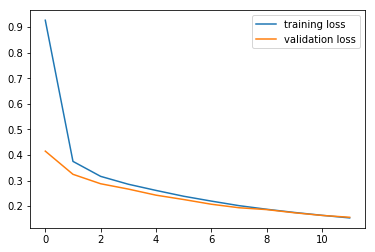

In [10]:
plt.plot(losses, label="training loss")
plt.plot(val_losses, label="validation loss")
plt.legend()

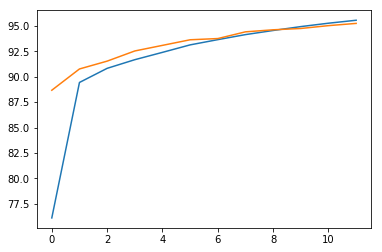

In [11]:
plt.plot(accuracies, label="train accuracy")
plt.plot(val_accuracies, label="val accuracy")

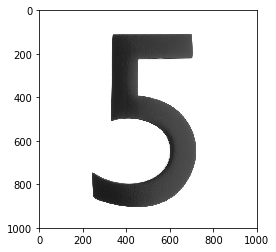

In [12]:
import requests
from PIL import Image
import PIL

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream=True)

img = Image.open(response.raw)
plt.imshow(img)

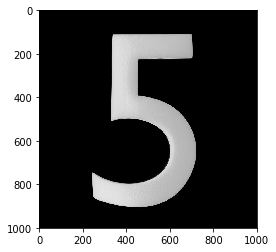

In [13]:
# mnistの写真に寄せておく
img = PIL.ImageOps.invert(img) #白黒反転
plt.imshow(img)

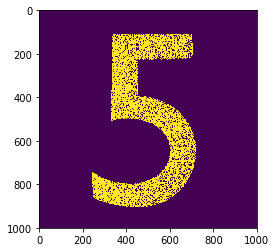

In [14]:
img = img.convert("1")
plt.imshow(img)

In [0]:
img = transform(img)

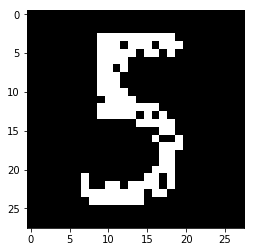

In [16]:
plt.imshow(im_convert(img))

In [17]:
img = img.view(img.shape[0], -1)
outputs = model(img)
_, val_pred = torch.max(outputs, 1)
print(pred.item_())

NameError: ignored

AttributeError: ignored

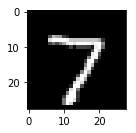

In [18]:
dataiter = iter(validation_loader) #iterableなtrain_loader
images, labels = dataiter.next()
images_ = images.view((images.shape[0], -1))
output = model(images_)
_, preds = torch.max(output, 1)



fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx + 1)
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{}, ({})".format(preds[idx].item(), str(labels).item()), color=("green" if preds==labels[idx] else "red"))
  
  